- [19.3 - Hierarchical Bayesian Approach](#19.3---Hierarchical-Bayesian-Approach)
- [19.4 - Adding a Metric Predictor](#19.4---Adding-a-Metric-Predictor)
- [19.5 - Heterogeneous Variances and Robustness against Outliers](#19.5---Heterogeneous-Variances-and-Robustness-against-Outliers)

## Chapter 19 - Metric Predicted Variable with One Nominal Predictor

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import norm
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [238]:
def plot_mustache(var, sd, j, width=.75):
    for i in np.arange(0, len(var), int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange*(width/xrange.max())
        
        # Using the negative value to flip the mustache in the right direction.
        plt.plot(-xrange_scaled+j, yrange, color=color, alpha=.6)

In [4]:
# Plot credible posterior distribution lines for model in section 19.4
def plot_cred_lines(b0, bj, bcov, x, ax):
   
    B = pd.DataFrame(np.c_[b0, bj, bcov], columns=['beta0', 'betaj', 'betacov'])
    
    # Credible posterior prediction lines
    hpd_interval = pmc.hpd(B.as_matrix(), alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & 
              B.betaj.between(*hpd_interval[1,:]) &
              B.betacov.between(*hpd_interval[2,:])] 
    xrange = np.linspace(x.min()*.95, x.max()*1.05)
   
    for i in np.random.randint(0, len(B_hpd), 10):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]+B_hpd.iloc[i,2]*xrange, c=color, alpha=.6, zorder=0)    

### 19.3 - Hierarchical Bayesian Approach

In [187]:
df = pd.read_csv('data/FruitflyDataReduced.csv')
df.CompanionNumber = df.CompanionNumber.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
Longevity          125 non-null int64
CompanionNumber    125 non-null category
Thorax             125 non-null float64
dtypes: category(1), float64(1), int64(1)
memory usage: 2.2 KB


In [188]:
df.groupby('CompanionNumber').head(2)

     Longevity CompanionNumber  Thorax
0           35       Pregnant8    0.64
1           37       Pregnant8    0.68
25          40           None0    0.64
26          37           None0    0.70
50          46       Pregnant1    0.64
51          42       Pregnant1    0.68
75          21         Virgin1    0.68
76          40         Virgin1    0.68
100         16         Virgin8    0.64
101         19         Virgin8    0.64

In [189]:
# Count the number of records per nominal group
df.CompanionNumber.value_counts()

Virgin8      25
Virgin1      25
Pregnant8    25
Pregnant1    25
None0        25
Name: CompanionNumber, dtype: int64

In [190]:
df.CompanionNumber.cat.categories

Index(['None0', 'Pregnant1', 'Pregnant8', 'Virgin1', 'Virgin8'], dtype='object')

In [191]:
df.CompanionNumber.cat.codes.values

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

#### Model (Kruschke, 2015)

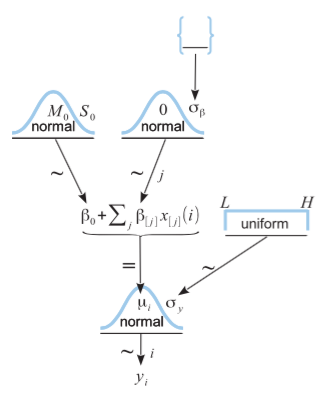

In [192]:
Image('images/fig19_2.png')

In [193]:
x = df.CompanionNumber.cat.codes.values
y = df.Longevity
yMean = y.mean()
ySD = y.std()

NxLvl = len(df.CompanionNumber.cat.categories)

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pmc.Model() as model1:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pmc.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pmc.Uniform('ySigma', ySD/100, ySD*10)
    y = pmc.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pmc.Deterministic('m', a0 + a)
    b0 = pmc.Deterministic('b0', tt.mean(m))
    b = pmc.Deterministic('b', m - b0) 

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied interval-transform to ySigma and added transformed ySigma_interval_ to model.


In [194]:
with model1:
    trace1 = pmc.sample(10000)

Assigned NUTS to aSigma_log_
Assigned NUTS to a0
Assigned NUTS to a
Assigned NUTS to ySigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 20.3 sec

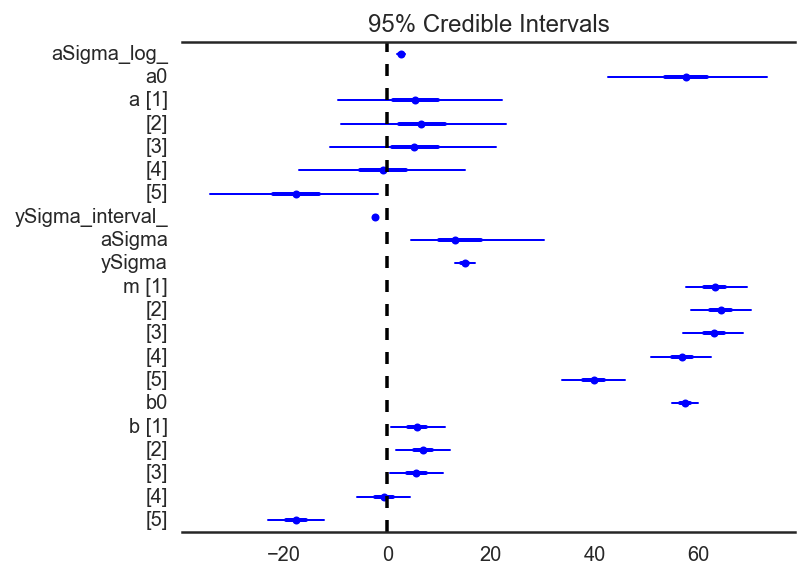

In [195]:
pmc.forestplot(trace1);

In [196]:
pmc.df_summary(trace1)

             mean        sd  mc_error    hpd_2.5   hpd_97.5
a0      57.625856  8.001723  0.245313  42.590144  73.344435
a__0     5.562785  8.339116  0.246263  -9.448239  22.232508
a__1     6.729262  8.356930  0.245201  -8.996799  22.976270
a__2     5.408157  8.312975  0.244815 -11.072843  21.025887
a__3    -0.820897  8.348757  0.249130 -16.995445  15.027351
a__4   -17.772449  8.395142  0.242192 -34.218937  -1.758814
aSigma  15.270980  8.333129  0.199193   4.526157  30.190762
ySigma  14.984998  1.238144  0.019766  13.137095  16.887816
m__0    63.188641  2.982314  0.026305  57.661034  69.307797
m__1    64.355118  2.974609  0.025559  58.604623  70.245220
m__2    63.034014  2.968435  0.023065  56.993445  68.578469
m__3    56.804959  2.908396  0.024065  50.974765  62.427838
m__4    39.853407  3.088069  0.030474  33.771072  45.813186
b0      57.447228  1.325859  0.011212  54.870056  59.988178
b__0     5.741413  2.669104  0.021677   0.651715  11.140994
b__1     6.907890  2.647941  0.023179   

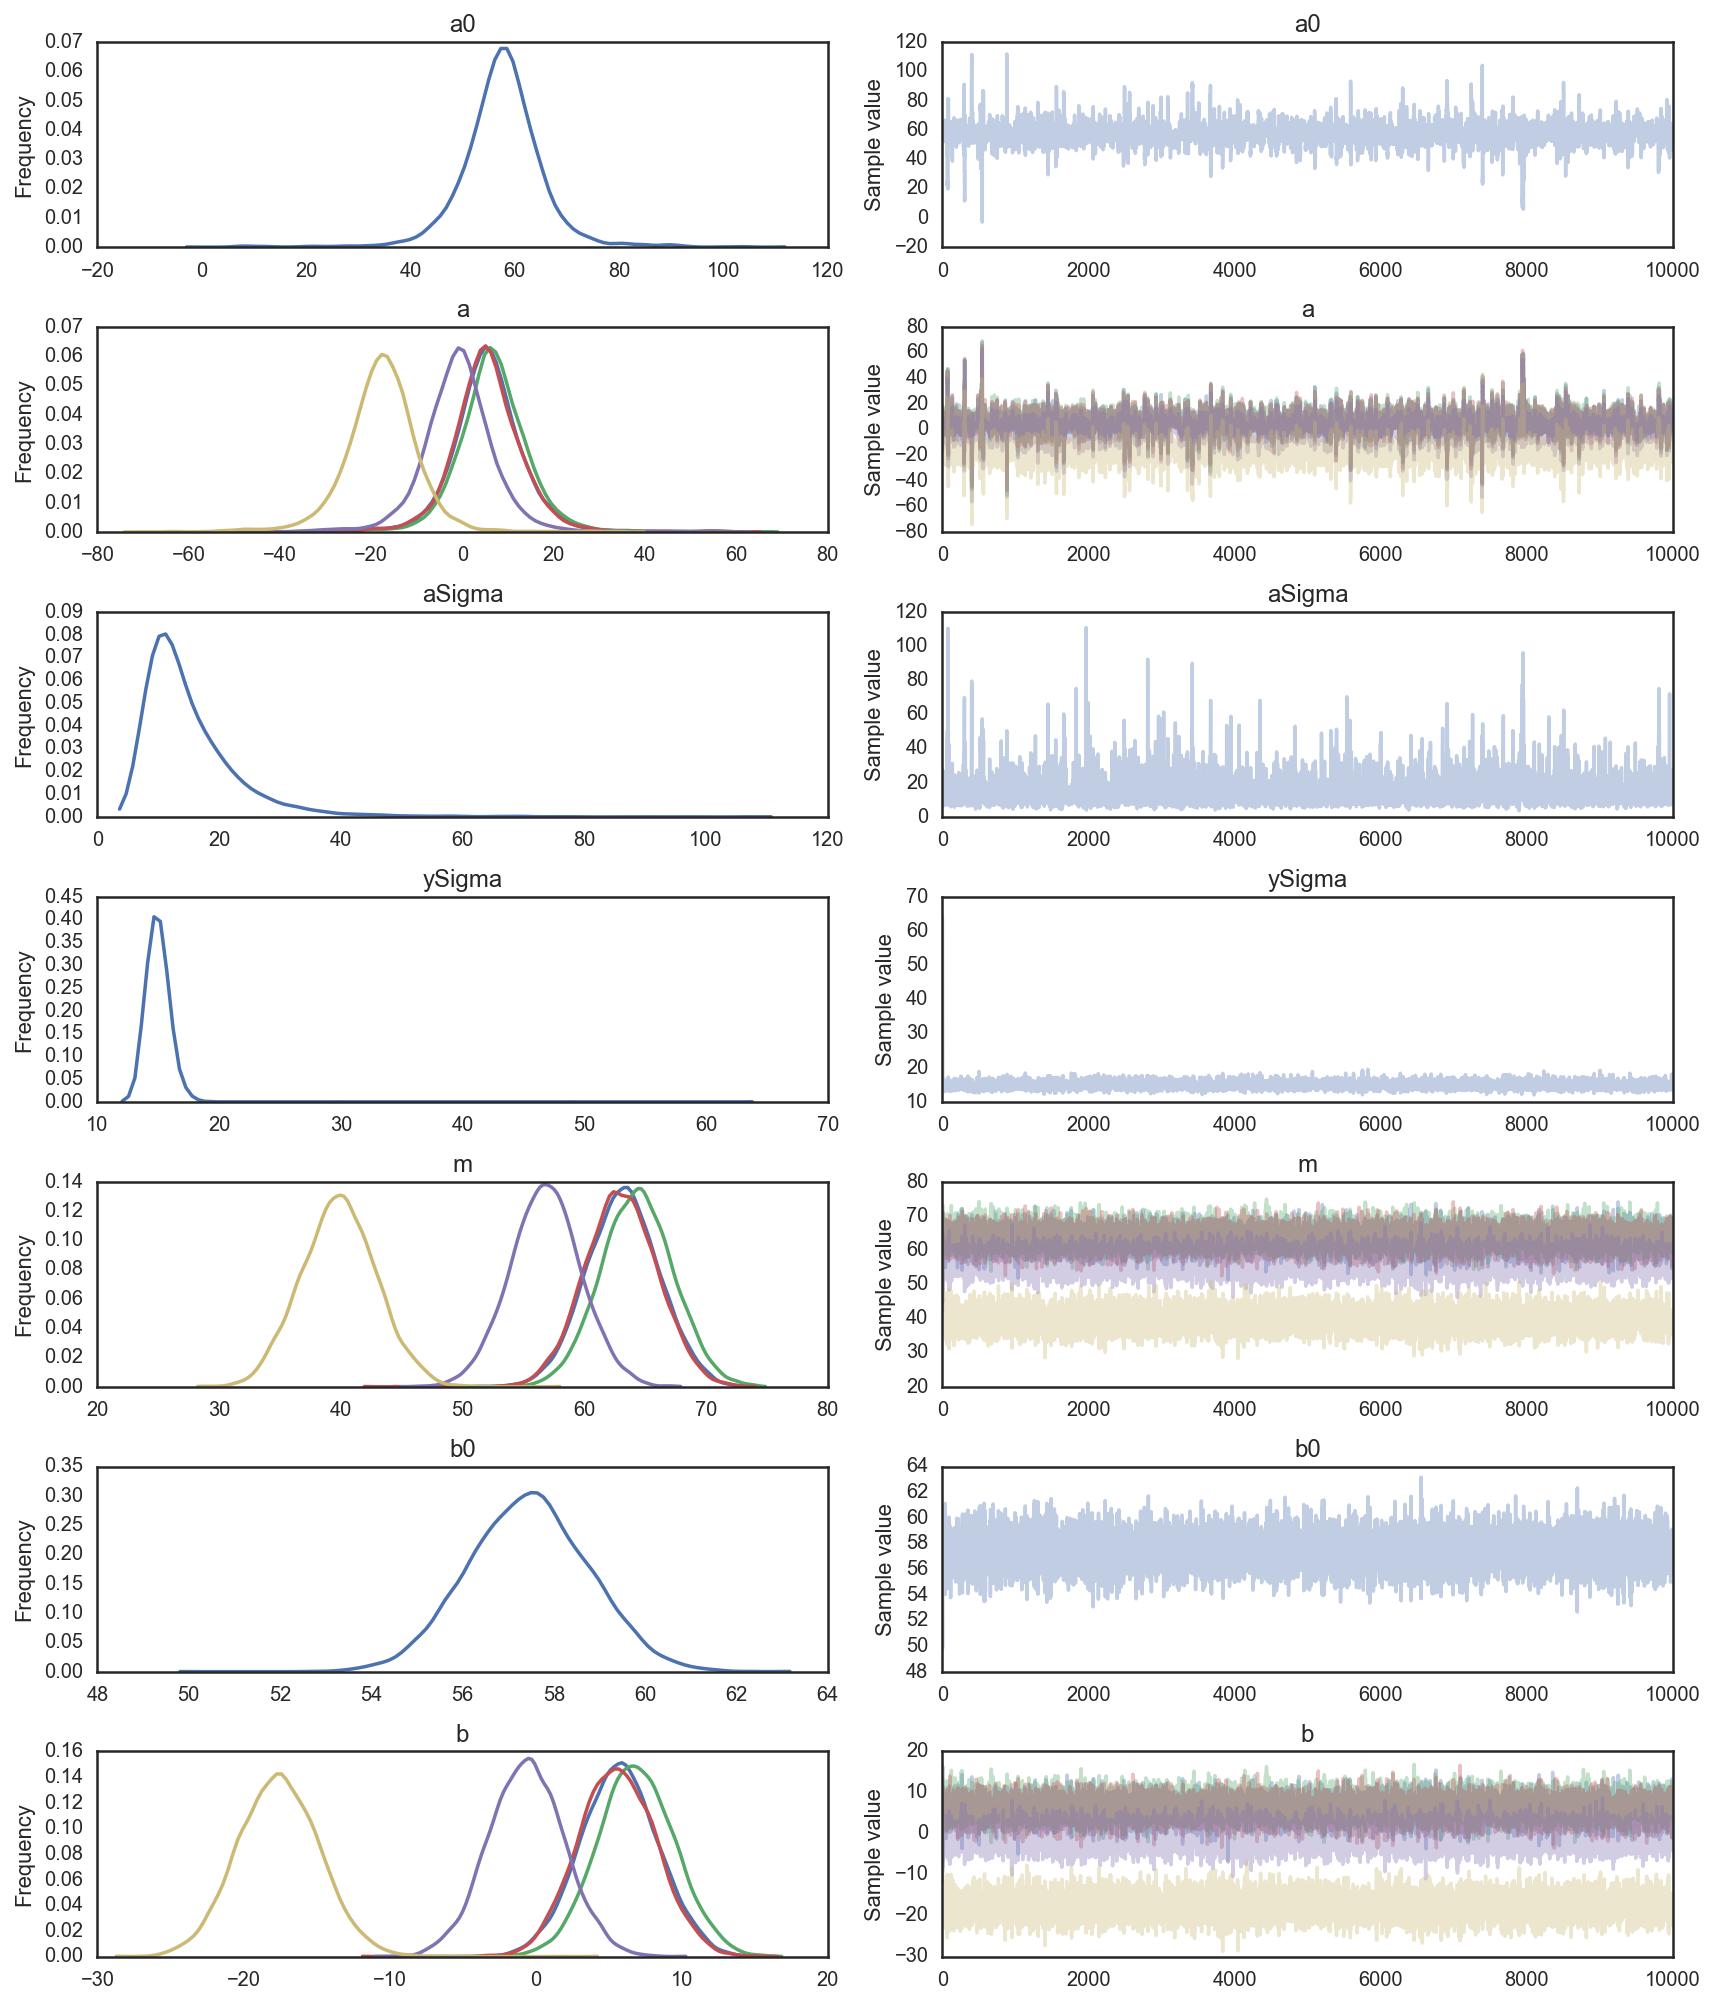

In [197]:
pmc.traceplot(trace1);

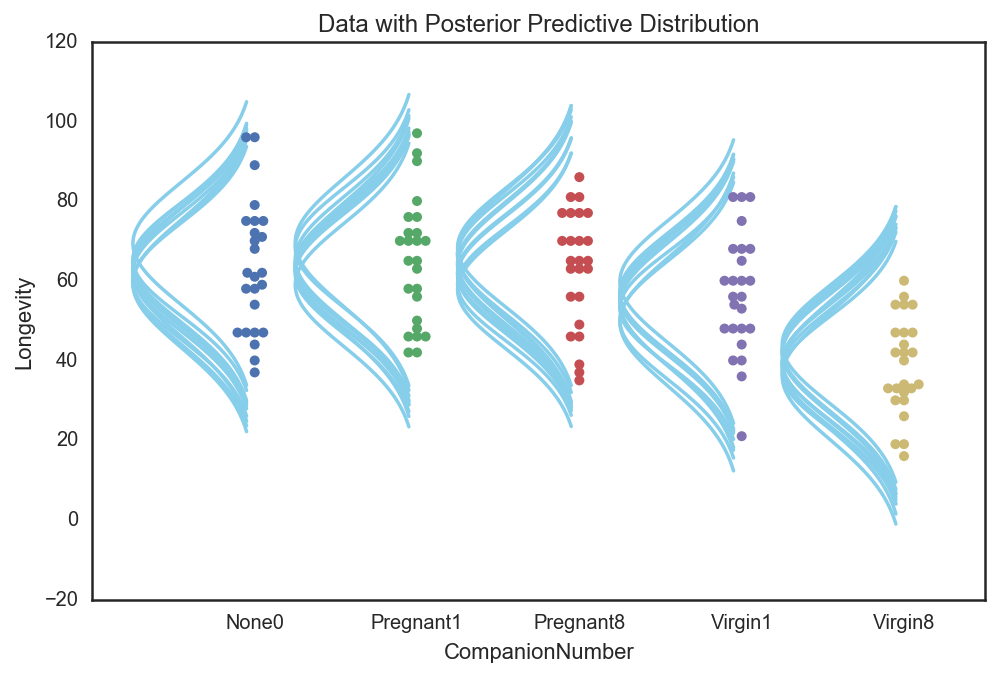

In [198]:
# Here we plot the metric predicted variable for each group. Then we superimpose the 
# posterior predictive distribution
burnin = 200

None0 = trace1['m'][burnin:,0]
Pregnant1 = trace1['m'][burnin:,1]
Pregnant8 = trace1['m'][burnin:,2]
Virgin1 = trace1['m'][burnin:,3]
Virgin8 = trace1['m'][burnin:,4]
scale = trace1['ySigma'][burnin:]

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.set_title('Data with Posterior Predictive Distribution')

sns.swarmplot('CompanionNumber', 'Longevity', data=df, ax=ax);
ax.set_xlim(xmin=-1)

for i, grp in enumerate([None0, Pregnant1, Pregnant8, Virgin1, Virgin8]):
    plot_mustache(grp, scale, i)

#### Contrasts

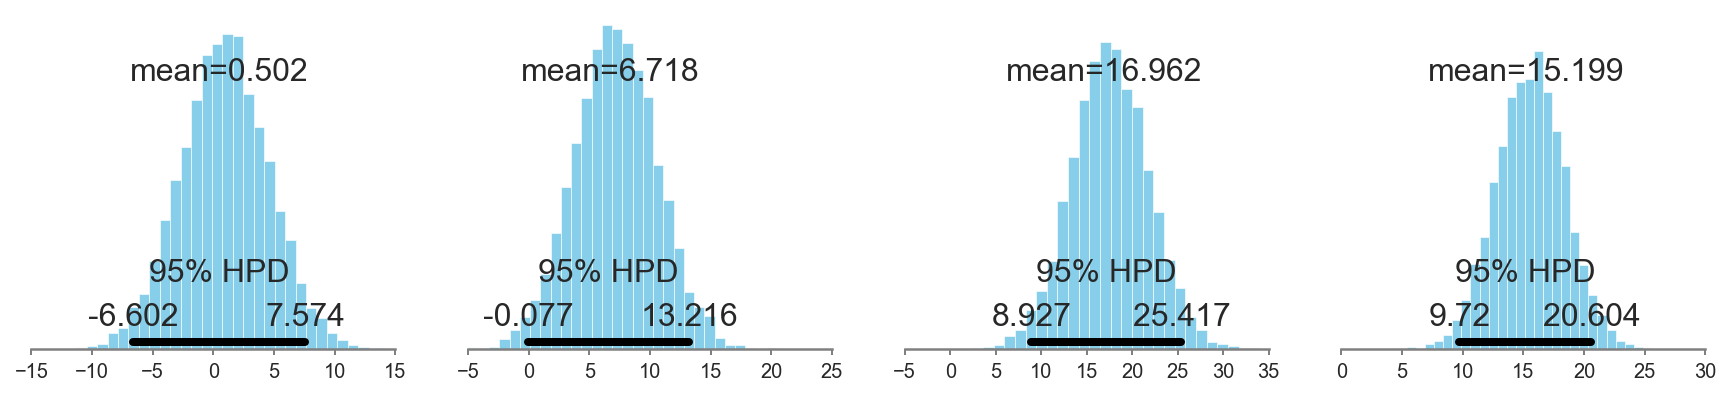

In [200]:
fig, axes = plt.subplots(1,4, figsize=(15,3))

pmc.plot_posterior(np.mean([Pregnant1, Pregnant8], axis=0)-None0, color=color, ax=axes[0])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1, color=color, ax=axes[1])
pmc.plot_posterior(Virgin1-Virgin8, color=color, ax=axes[2])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0), color=color, ax=axes[3])

### 19.4 - Adding a Metric Predictor

#### Model (Kruschke, 2015)

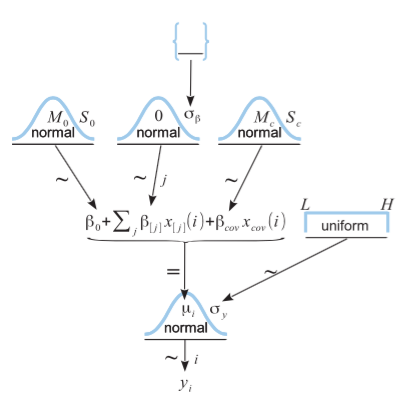

In [201]:
Image('images/fig19_4.png')

In [208]:
y = df.Longevity
yMean = y.mean()
ySD = y.std()
xNom = df.CompanionNumber.cat.categories
xMet = df.Thorax
xMetMean = df.Thorax.mean()
xMetSD = df.Thorax.std()
NxNomLvl = len(df.CompanionNumber.cat.categories)

X = pd.concat([df.Thorax, pd.get_dummies(df.CompanionNumber, drop_first=True)], axis=1)
lmInfo = LinearRegression().fit(X, y)
residSD = np.sqrt(mean_squared_error(y, lmInfo.predict(X)))

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pmc.Model() as model2:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pmc.Normal('a', 0.0, tau=1/aSigma**2, shape=NxNomLvl)
    aMet = pmc.Normal('aMet', 0, tau=1/(2*ySD/xMetSD)**2)
       
    ySigma = pmc.Uniform('ySigma', residSD/100, ySD*10)
    
    mu = a0 + a[x] + aMet*(xMet - xMetMean)
    y = pmc.Normal('y', mu, tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    b0 = pmc.Deterministic('b0', a0 + tt.mean(a) + aMet*(-xMetMean))
    b = pmc.Deterministic('b', a - tt.mean(a)) 

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied interval-transform to ySigma and added transformed ySigma_interval_ to model.


In [209]:
with model2:
    trace2 = pmc.sample(10000)

Assigned NUTS to aSigma_log_
Assigned NUTS to a0
Assigned NUTS to a
Assigned NUTS to aMet
Assigned NUTS to ySigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 26.0 sec

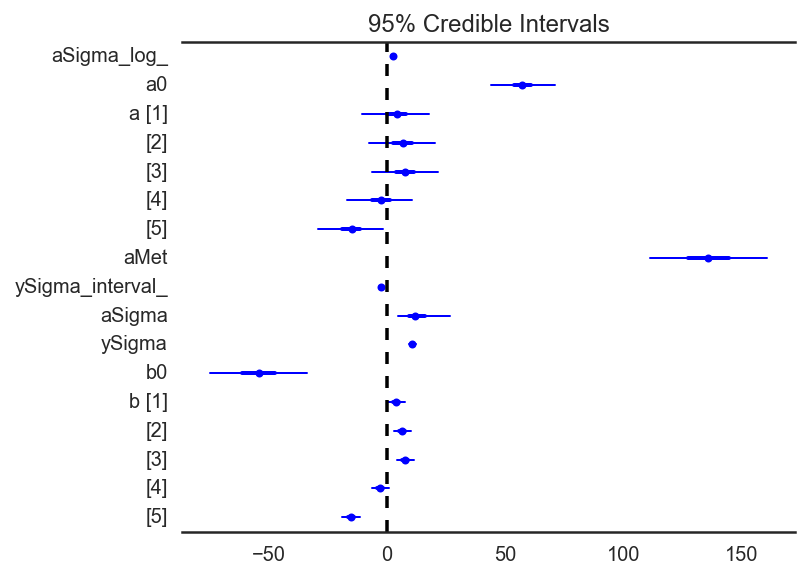

In [210]:
pmc.forestplot(trace2);

In [211]:
pmc.df_summary(trace2)

              mean         sd  mc_error     hpd_2.5    hpd_97.5
a0       57.410192   6.642935  0.194568   44.005114   71.104824
a__0      3.920522   6.852630  0.192482  -10.422406   17.571232
a__1      6.466066   6.883675  0.196882   -7.740648   20.318479
a__2      7.725221   6.864177  0.200004   -6.419373   21.348551
a__3     -2.791471   6.842582  0.193689  -16.981688   10.732179
a__4    -15.224145   6.873870  0.195917  -29.284076   -1.917335
aMet    136.028788  12.767789  0.110356  111.103639  160.976681
aSigma   13.685706   6.984747  0.144325    4.797971   26.764791
ySigma   10.656894   1.053278  0.018961    9.339453   12.121845
b0      -54.244763  10.509679  0.090885  -75.028422  -33.899353
b__0      3.901283   1.886877  0.015690    0.325343    7.704124
b__1      6.446828   1.920749  0.016569    2.764986   10.190657
b__2      7.705982   1.895654  0.018581    4.091850   11.516743
b__3     -2.810710   1.885391  0.017278   -6.504195    0.829111
b__4    -15.243384   1.973909  0.018488 

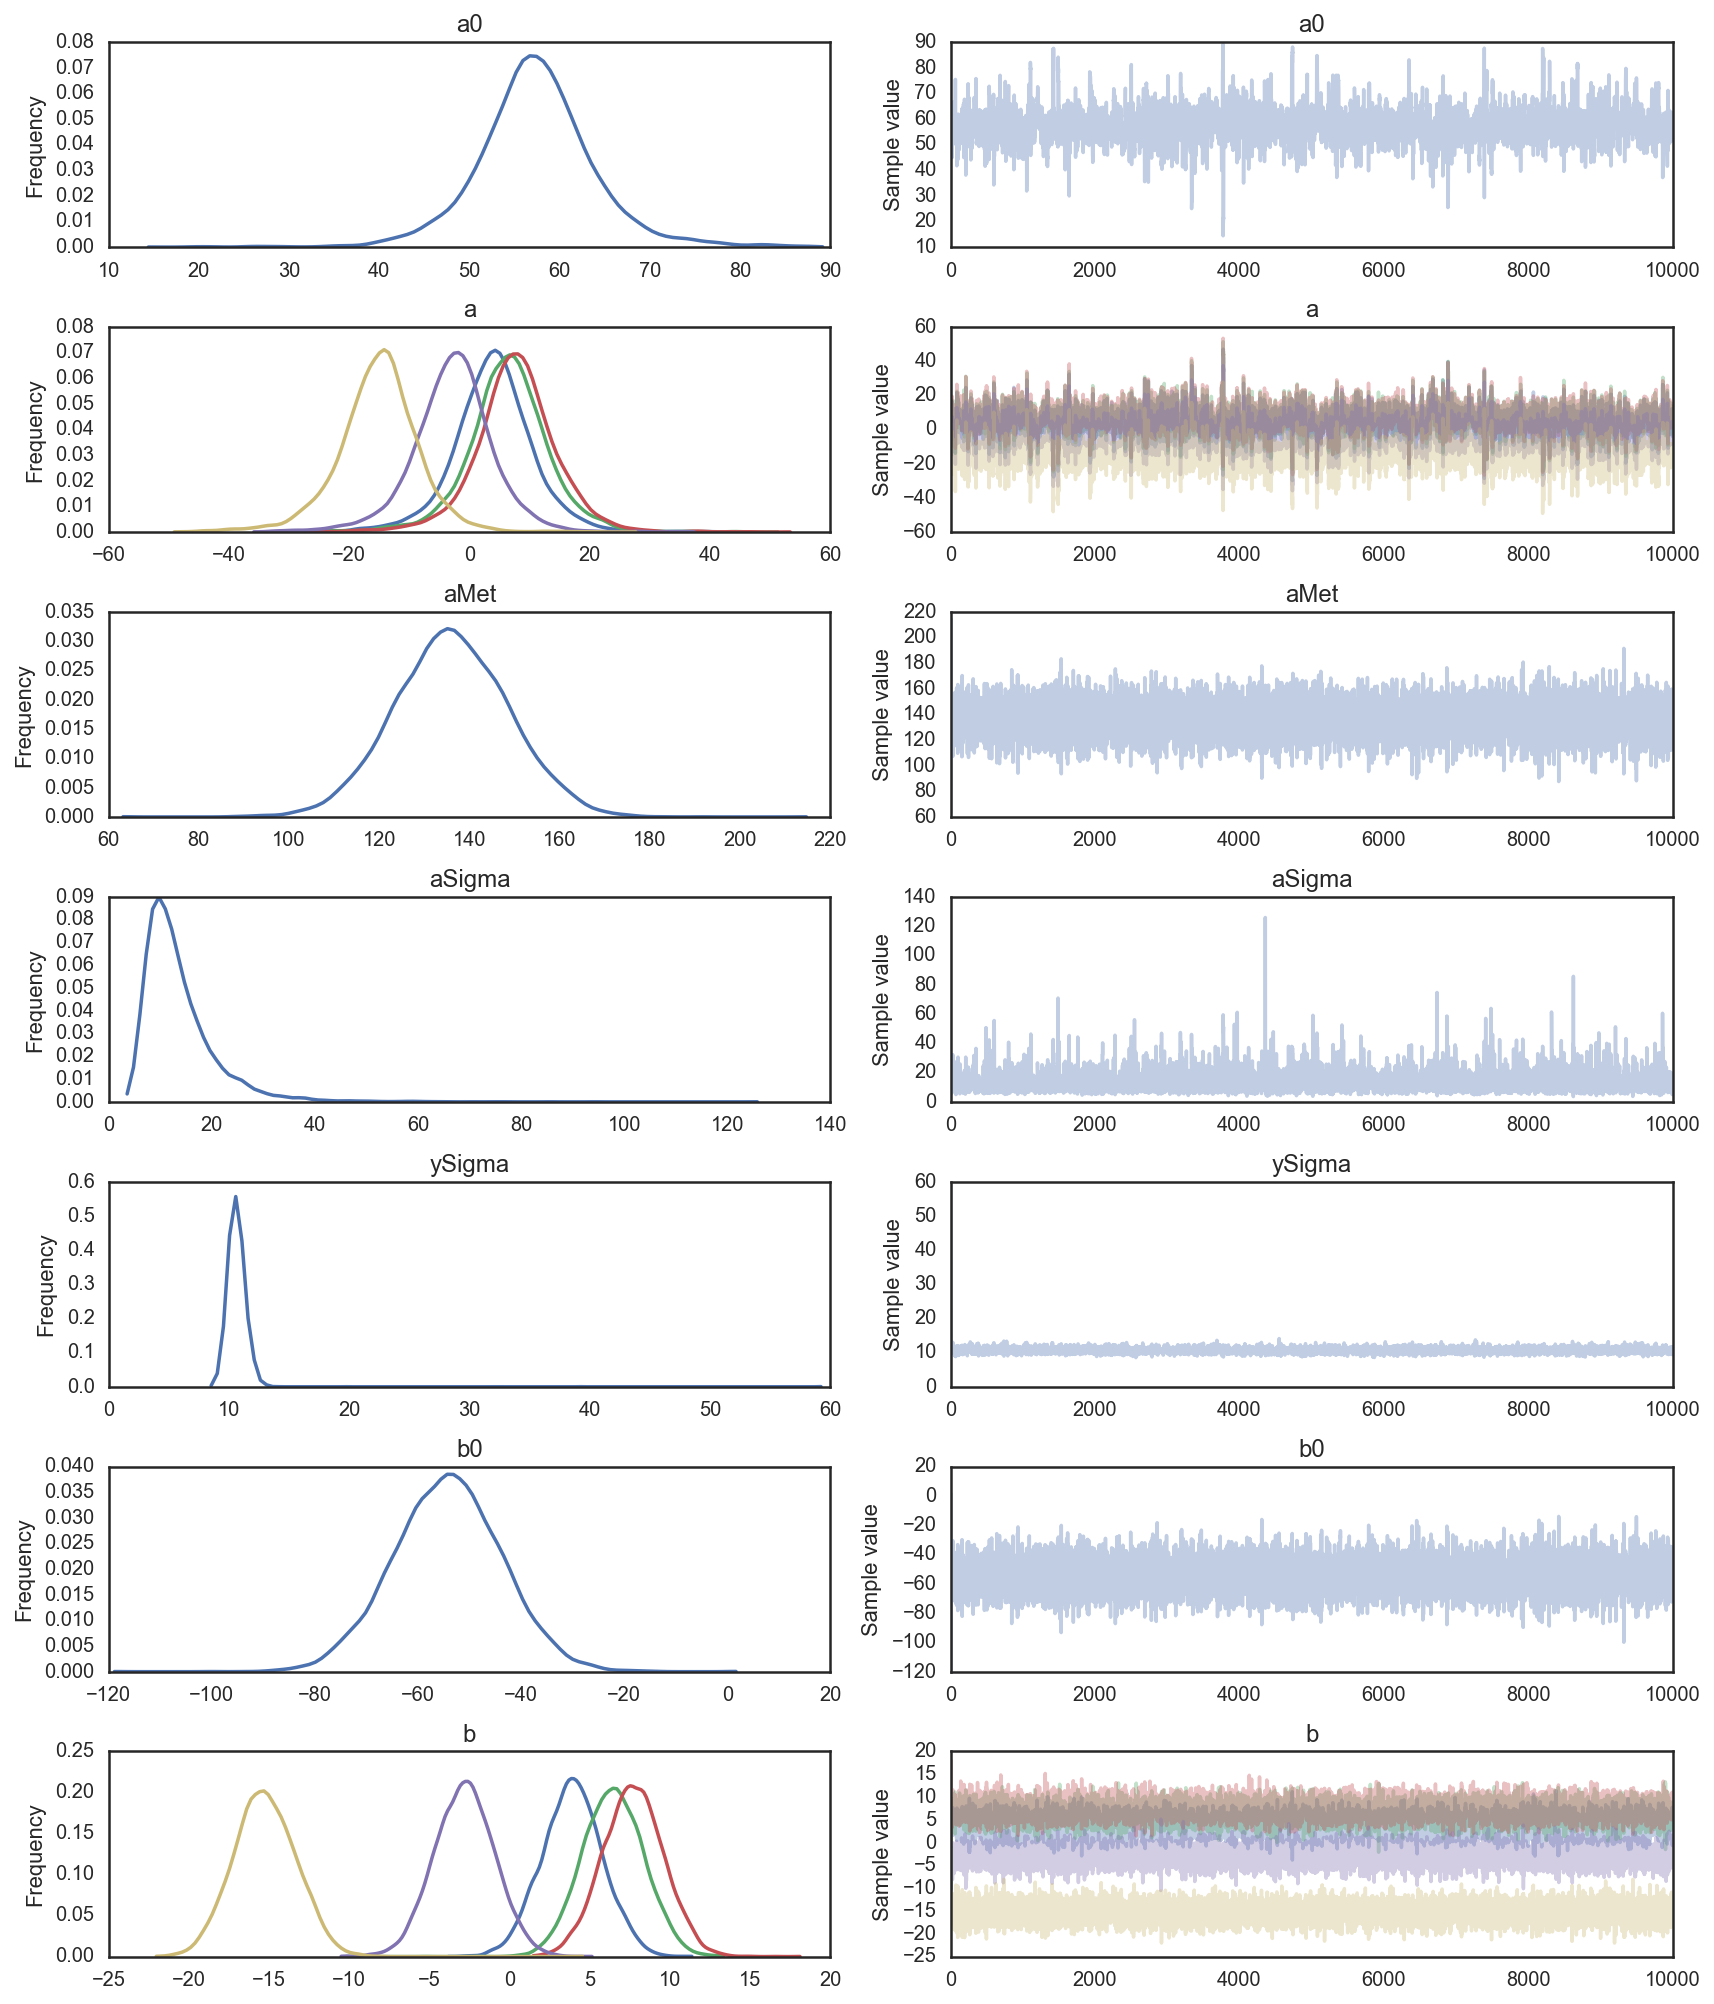

In [212]:
pmc.traceplot(trace2);

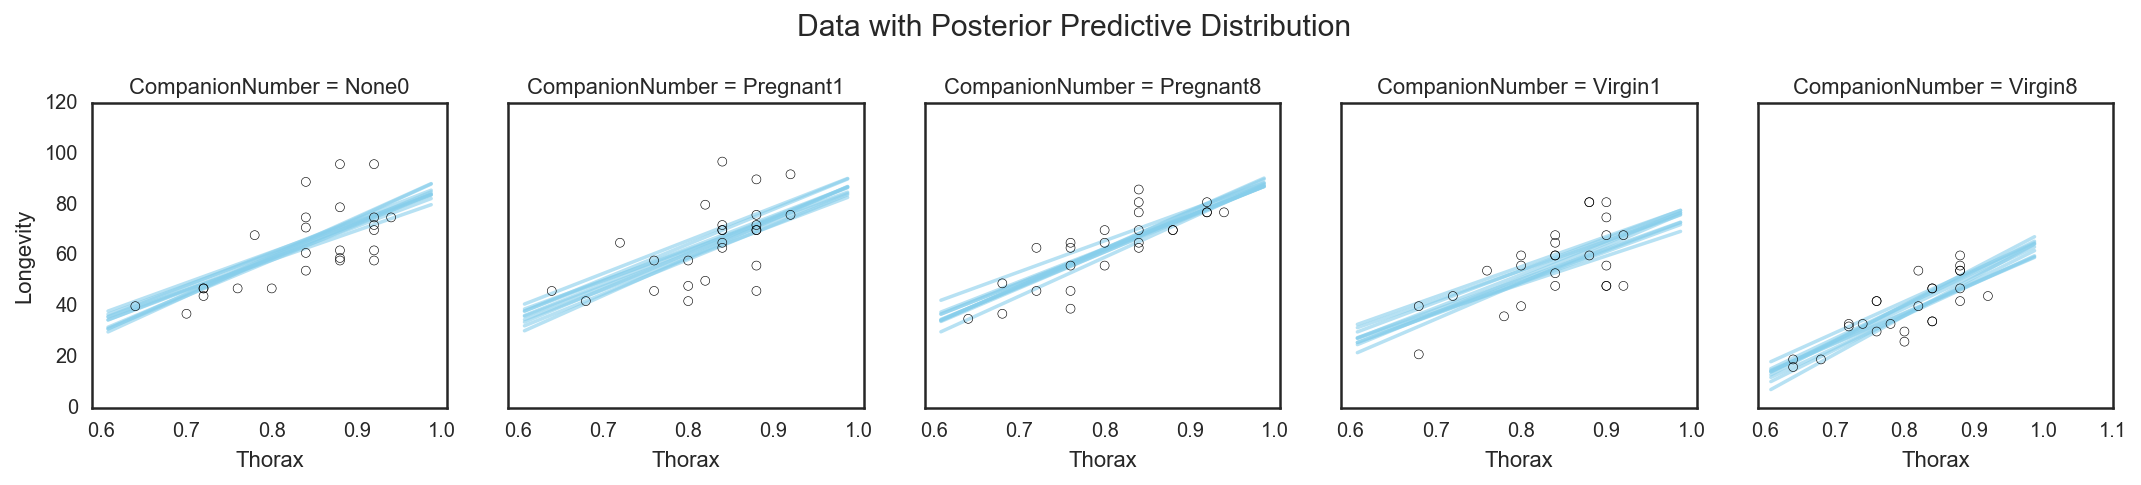

In [213]:
# Here we plot, for every group, the predicted variable and the metric predictor.
# Superimposed are are the posterior predictive distributions.
fg = sns.FacetGrid(df, col='CompanionNumber', despine=False)
fg.map(plt.scatter, 'Thorax', 'Longevity', facecolor='none', edgecolor='k')

plt.suptitle('Data with Posterior Predictive Distribution', y=1.10, fontsize=15)
for i, ax in enumerate(fg.axes.flatten()):
    plot_cred_lines(trace2['b0'][burnin:],
                    trace2['b'][burnin:,i],
                    trace2['aMet'][burnin:],
                    xMet, ax)
    ax.set_xticks(np.arange(.6, 1.1, .1));

#### Contrasts

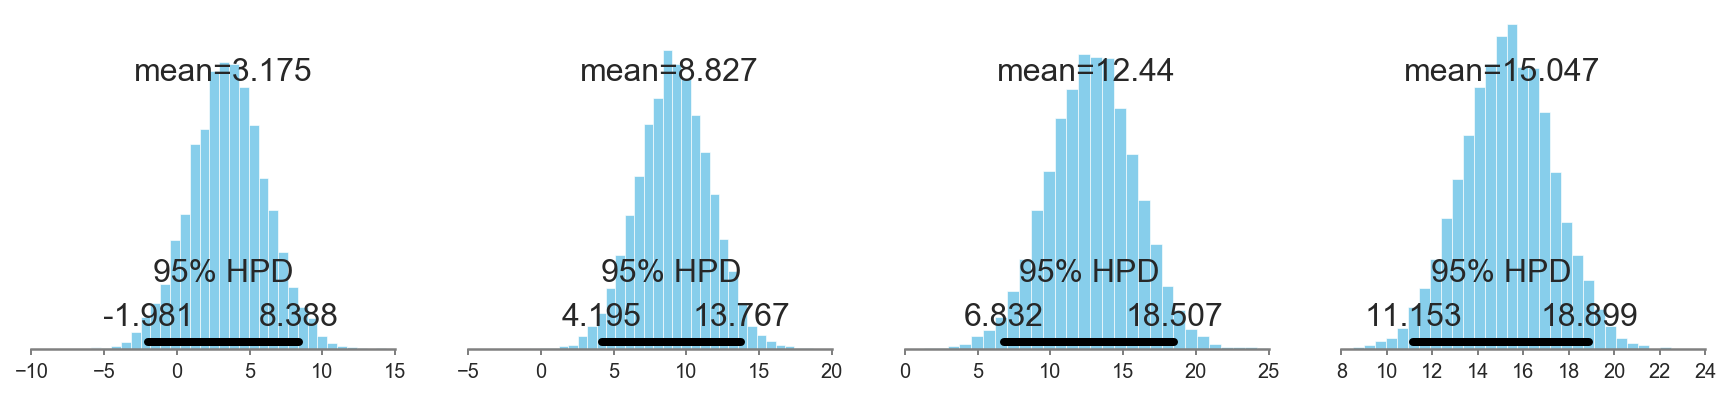

In [214]:
burnin = 200

None0 = trace2['b'][burnin:,0]
Pregnant1 = trace2['b'][burnin:,1]
Pregnant8 = trace2['b'][burnin:,2]
Virgin1 = trace2['b'][burnin:,3]
Virgin8 = trace2['b'][burnin:,4]
scale = trace2['ySigma'][burnin:]

fig, axes = plt.subplots(1,4, figsize=(15,3))

pmc.plot_posterior(np.mean([Pregnant1, Pregnant8], axis=0)-None0, color=color, ax=axes[0])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1, color=color, ax=axes[1])
pmc.plot_posterior(Virgin1-Virgin8, color=color, ax=axes[2])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0), color=color, ax=axes[3])

In [215]:
Virgin1-Virgin8

array([ 13.01724092,  15.30619811,  16.37873177, ...,  10.65748803,
        12.61021029,  11.04549208])

### 19.5 - Heterogeneous Variances and Robustness against Outliers

In [5]:
df2 = pd.read_csv('data/NonhomogVarData.csv')
df2.Group = df2.Group.astype('category')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
Group    96 non-null category
Y        96 non-null float64
dtypes: category(1), float64(1)
memory usage: 976.0 bytes


In [6]:
df2.groupby('Group').head(3)

   Group           Y
0      A   97.770214
1      A   99.919872
2      A   92.372917
24     B   98.246778
25     B   98.736006
26     B   98.722708
48     C  102.432580
49     C  102.198665
50     C  103.052658
72     D   97.561346
73     D   92.912256
74     D   96.500329

#### Model (Kruschke, 2015)

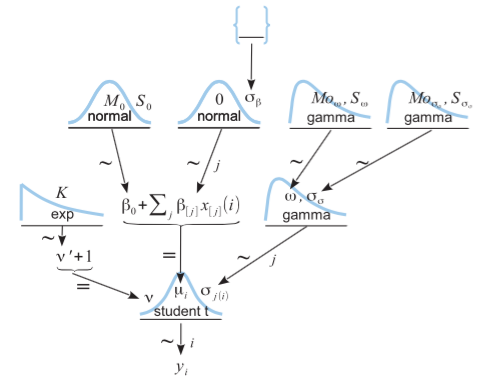

In [7]:
Image('images/fig19_6.png')

In [222]:
y = df2.Y
x = df2.Group.cat.codes.values
xlevels = df2.Group.cat.categories
NxLvl = len(xlevels) 
yMean = y.mean()
ySD = y.std()

aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)
medianCellSD = df2.groupby('Group').std().dropna().median()

with pmc.Model() as model3:
    
    aSigma = pmc.Gamma('aSigma', aGammaShRa[0], aGammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*10)**2)
    a = pmc.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
    
    ySigmaSD = pmc.Gamma('ySigmaSD', aGammaShRa[0], aGammaShRa[1])
    ySigmaMode = pmc.Gamma('ySigmaMode', aGammaShRa[0], aGammaShRa[1])
    ySigmaRa = (ySigmaMode + np.sqrt(ySigmaMode**2 + 4*ySigmaSD**2))/2*ySigmaSD**2
    ySigmaSh = ySigmaMode*ySigmaRa
        
    sigma = pmc.Gamma('sigma', ySigmaSh, ySigmaRa, shape=NxLvl)
    ySigma = pmc.Deterministic('ySigma', tt.maximum(sigma, medianCellSD/1000))
    nu = pmc.Exponential('nu', 1/30.)
    like = pmc.StudentT('y', nu=nu, mu=a0 + a[x], sd=ySigma[x], observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pmc.Deterministic('m', a0 + a)
    b0 = pmc.Deterministic('b0', tt.mean(m))
    b = pmc.Deterministic('b', m - b0) 

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied log-transform to ySigmaSD and added transformed ySigmaSD_log_ to model.
Applied log-transform to ySigmaMode and added transformed ySigmaMode_log_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


In [55]:
with model3:
    step = pmc.Metropolis()
    trace3 = pmc.sample(20000, step=step)
    #trace3 = pmc.sample(100)

 [-----------------100%-----------------] 20000 of 20000 complete in 14.5 sec

In [57]:
pmc.df_summary(trace3[5000:])

                  mean         sd  mc_error     hpd_2.5    hpd_97.5
a0          102.482757   2.938170  0.291318   98.718840  109.084561
a__0         -5.059902   3.616181  0.350642  -12.792344   -0.001973
a__1         -3.442344   2.940851  0.291175  -10.046368    0.302583
a__2         -0.475087   2.936145  0.290903   -7.202982    3.212455
a__3          0.751509   2.756344  0.261082   -4.824749    5.597748
aSigma        5.285395   3.867875  0.268090    0.763207   12.981190
ySigmaSD      0.292097   0.137316  0.005271    0.061508    0.562845
ySigmaMode    4.649858   2.355746  0.100362    1.231924    9.277077
sigma__0      7.545127   1.284966  0.047211    5.096548   10.126806
sigma__1      1.004325   0.173890  0.005907    0.702644    1.370562
sigma__2      0.979467   0.175909  0.006209    0.661673    1.345171
sigma__3      7.693313   1.280415  0.043347    5.434119   10.358674
ySigma__0     7.545127   1.284966  0.047211    5.096548   10.126806
ySigma__1     1.004325   0.173890  0.005907    0

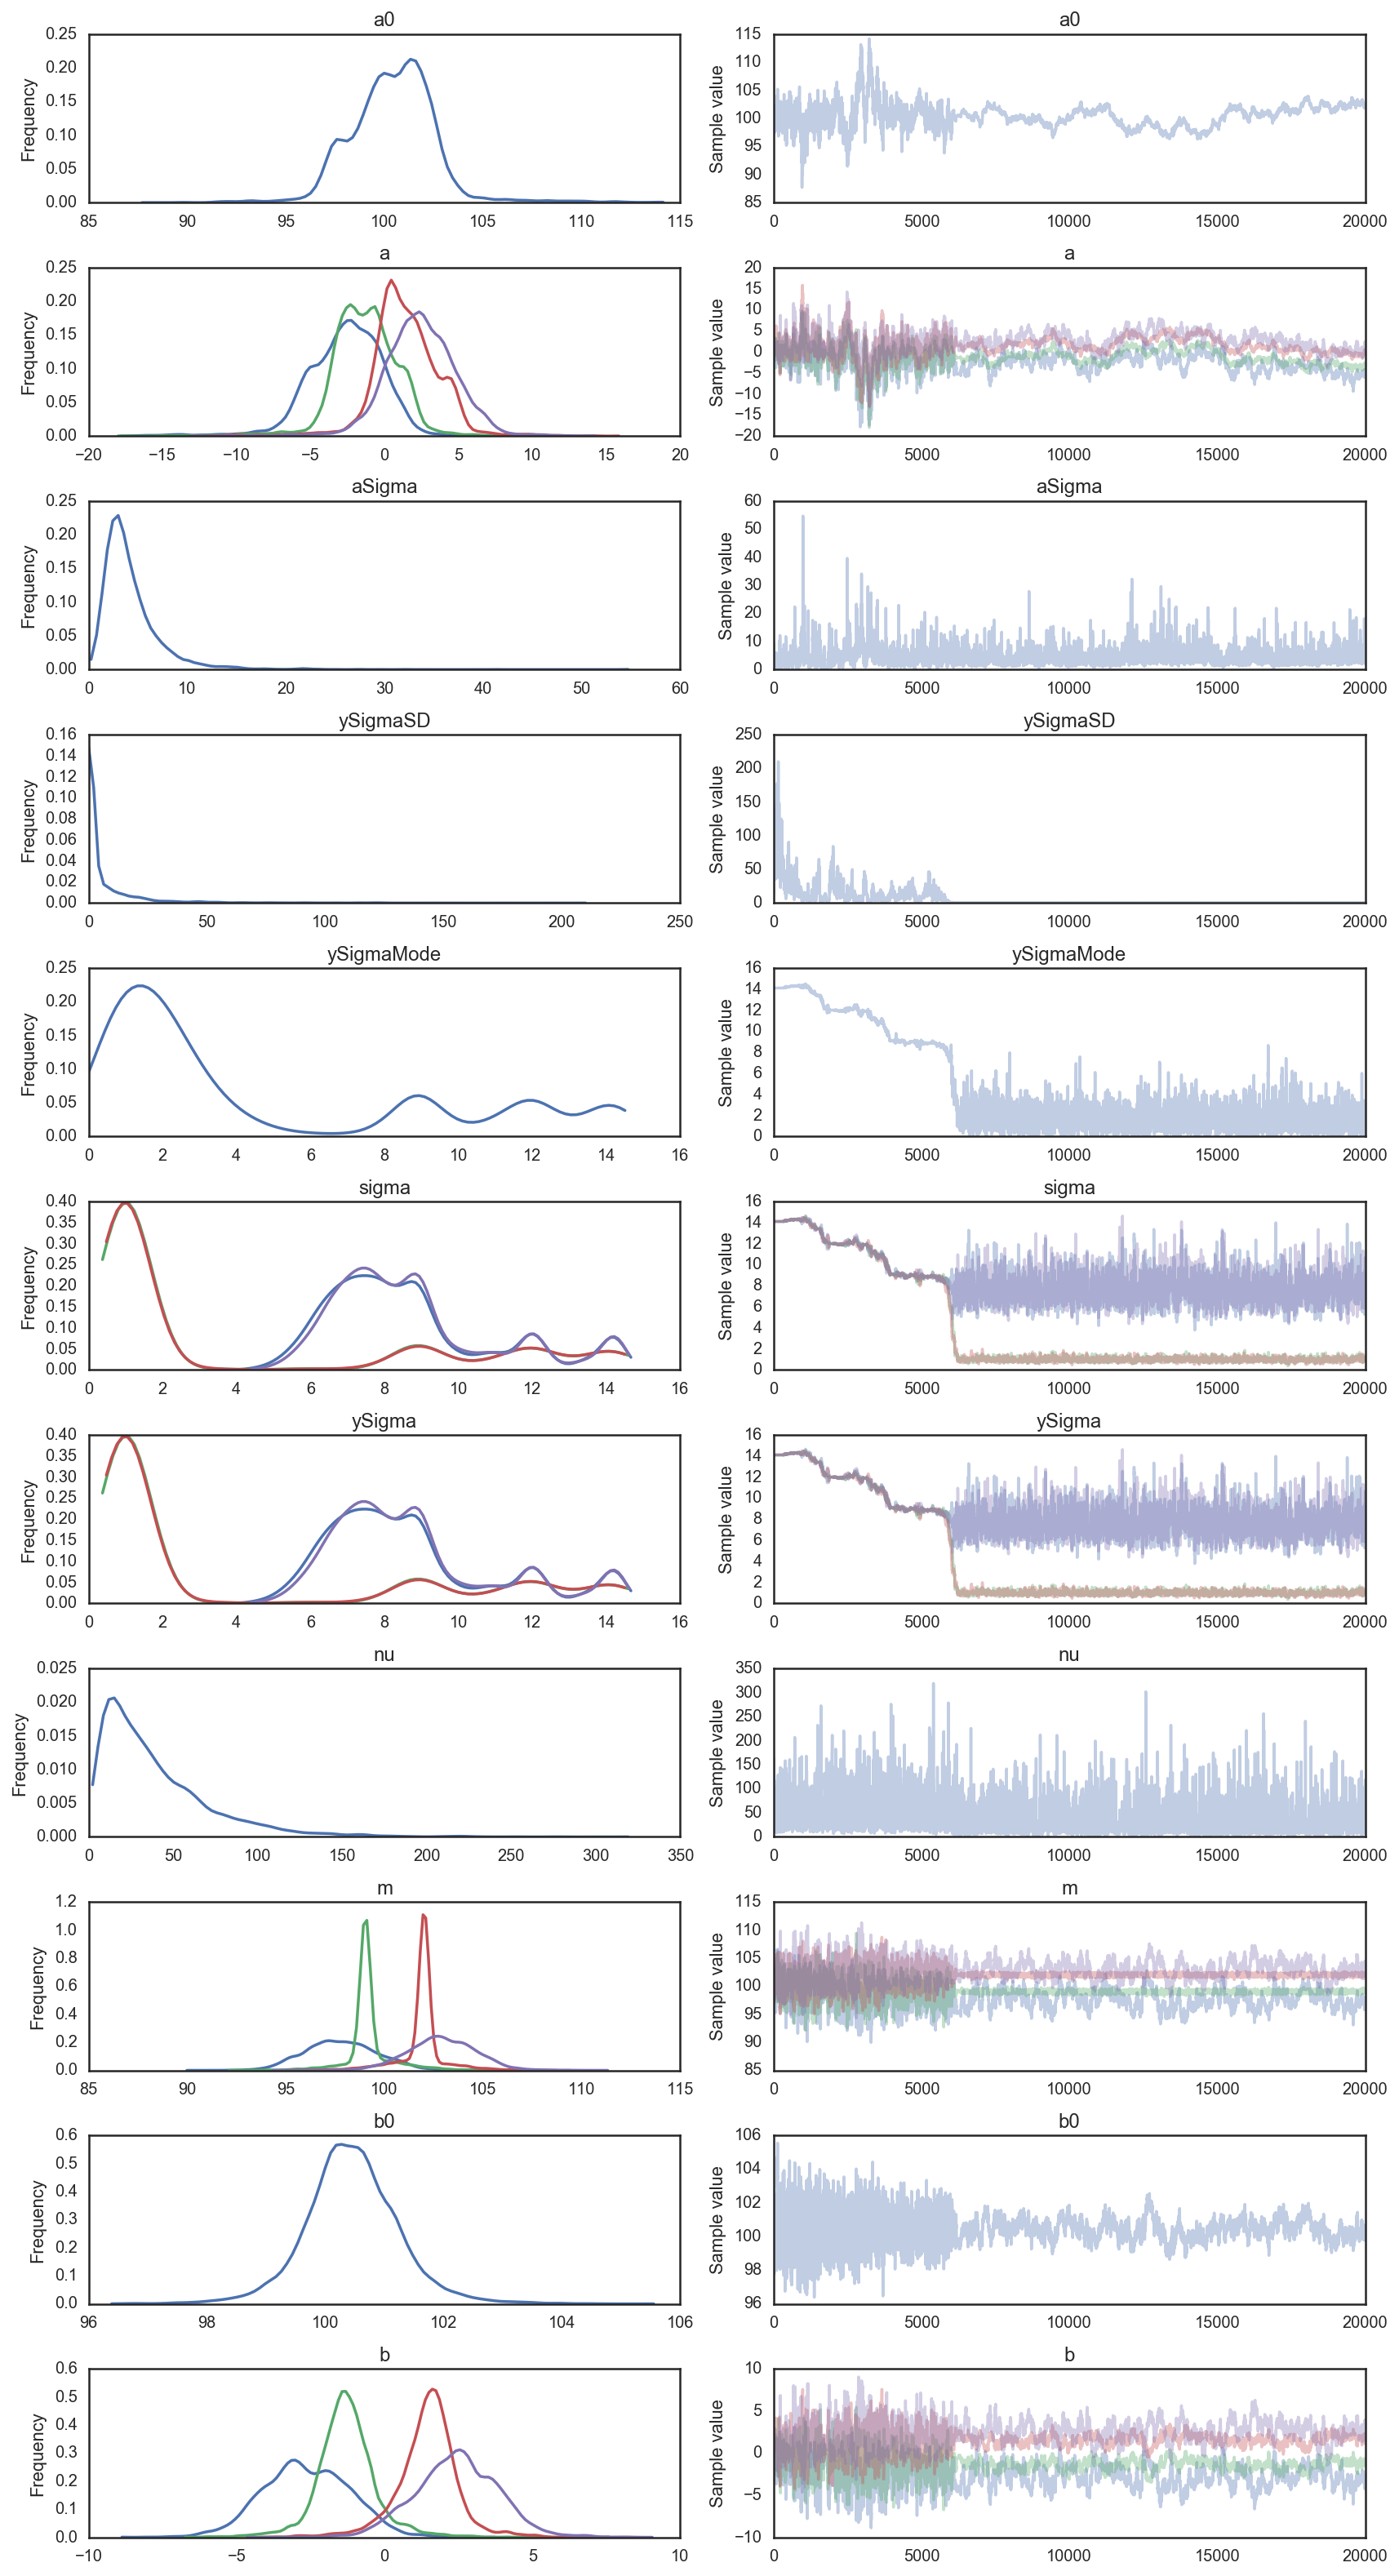

In [53]:
pmc.traceplot(trace3);

In [234]:
y = df2.Y
x = df2.Group.cat.codes.values
xlevels = df2.Group.cat.categories
NxLvl = len(xlevels) 
yMean = y.mean()
ySD = y.std()

aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pmc.Model() as model3b:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pmc.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pmc.Uniform('ySigma', ySD/100, ySD*10)
    y = pmc.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pmc.Deterministic('m', a0 + a)
    b0 = pmc.Deterministic('b0', tt.mean(m))
    b = pmc.Deterministic('b', m - b0) 
    
    step = pmc.Metropolis()
    trace3b = pmc.sample(20000, step)

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied interval-transform to ySigma and added transformed ySigma_interval_ to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 7.0 sec

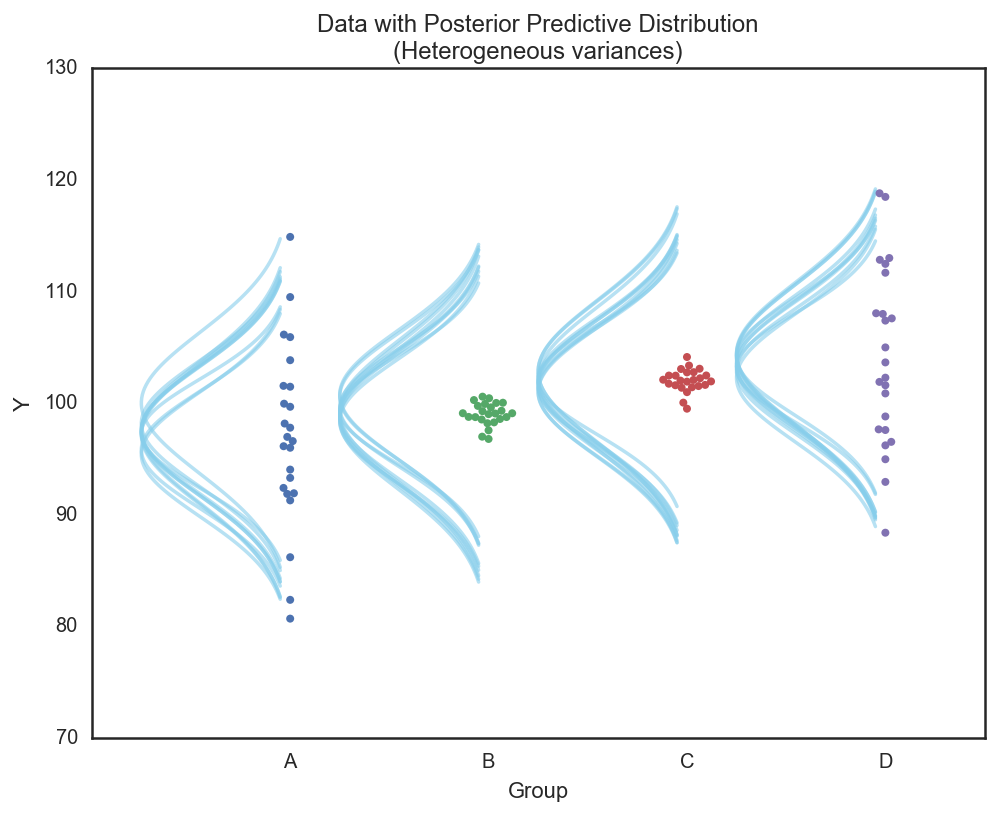

In [239]:
burnin = 5000

group_a = trace3b['m'][burnin:,0]
group_b = trace3b['m'][burnin:,1]
group_c = trace3b['m'][burnin:,2]
group_d = trace3b['m'][burnin:,3]
scale = trace3b['ySigma'][burnin:]
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_title('Data with Posterior Predictive Distribution\n(Heterogeneous variances)')

sns.swarmplot('Group', 'Y', data=df2, size=4, ax=ax)
ax.set_xlim(xmin=-1);

for i, grp, in enumerate([group_a, group_b, group_c, group_d]):
    plot_mustache(grp, scale, i)

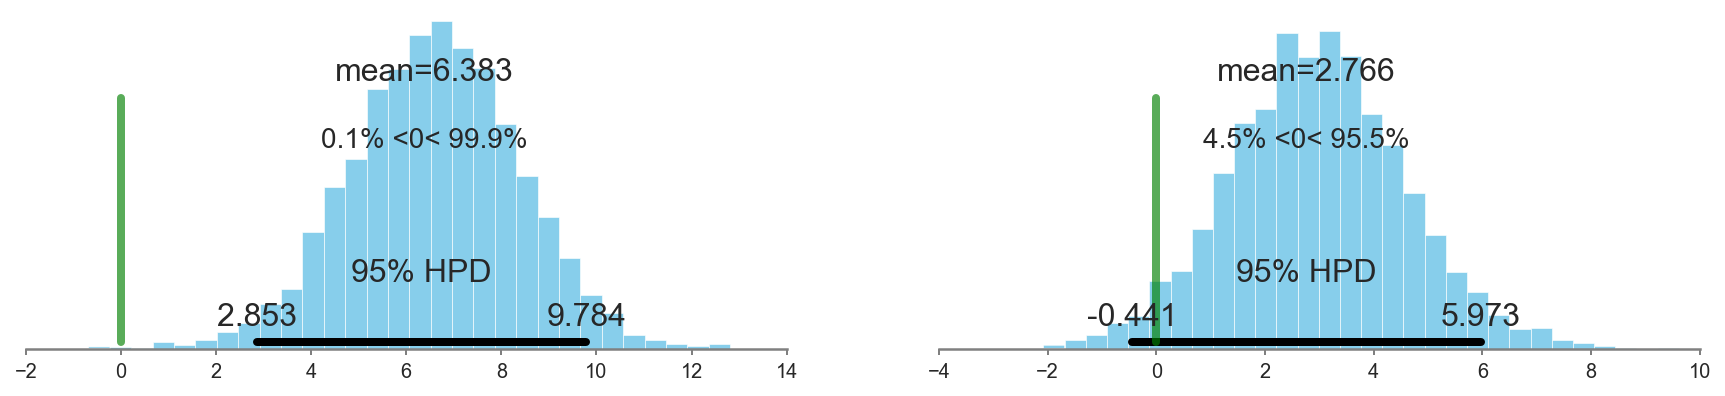

In [237]:
fig, axes = plt.subplots(1,2, figsize=(15,3))

pmc.plot_posterior(group_d-group_a, color=color, ref_val=0, ax=axes.flatten()[0])
pmc.plot_posterior(group_c-group_b, color=color, ref_val=0, ax=axes.flatten()[1])

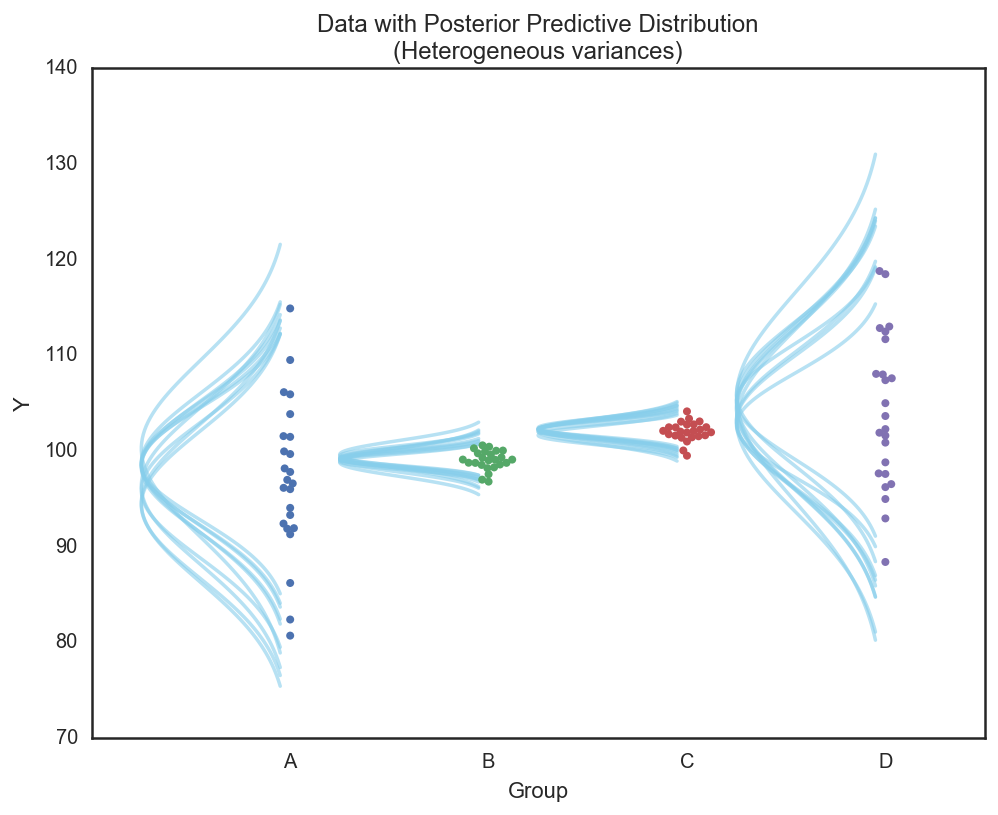

In [240]:
burnin = 5000

group_a = trace3['m'][burnin:,0]
group_b = trace3['m'][burnin:,1]
group_c = trace3['m'][burnin:,2]
group_d = trace3['m'][burnin:,3]
scale_a = trace3['ySigma'][burnin:,0]
scale_b = trace3['ySigma'][burnin:,1]
scale_c = trace3['ySigma'][burnin:,2]
scale_d = trace3['ySigma'][burnin:,3]

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_title('Data with Posterior Predictive Distribution\n(Heterogeneous variances)')

sns.swarmplot('Group', 'Y', data=df2, size=4, ax=ax)
ax.set_xlim(xmin=-1);

for i, (grp, scale) in enumerate(zip([group_a, group_b, group_c, group_d],
                                     [scale_a, scale_b, scale_c, scale_d])):
    plot_mustache(grp, scale, i)

#### Contrasts

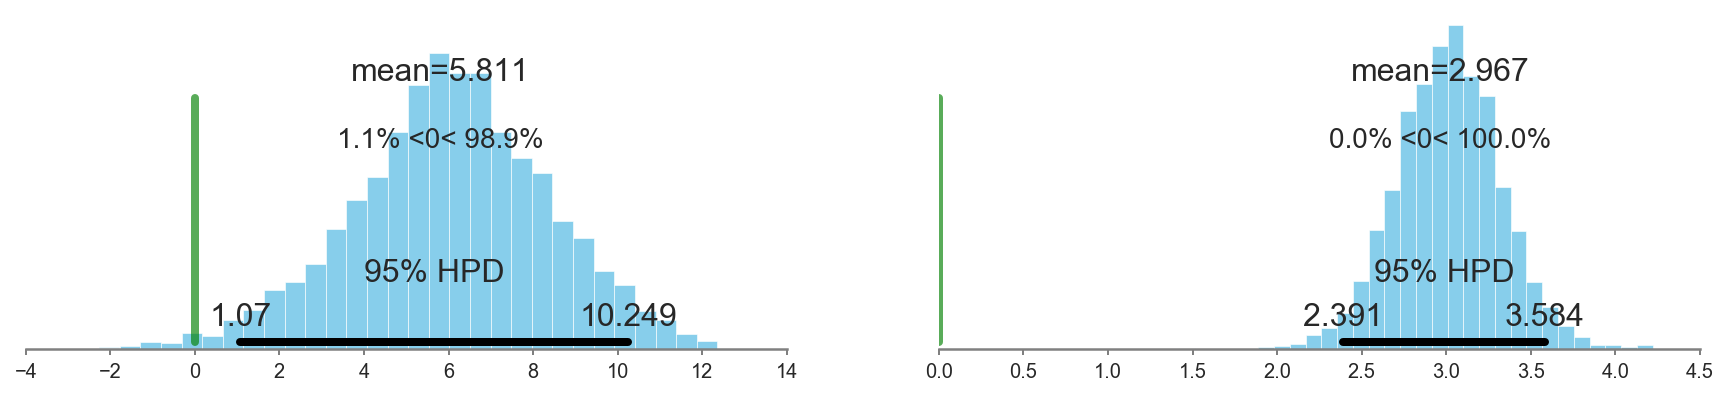

In [220]:
fig, axes = plt.subplots(1,2, figsize=(15,3))

pmc.plot_posterior(group_d-group_a, color=color, ref_val=0, ax=axes.flatten()[0])
pmc.plot_posterior(group_c-group_b, color=color, ref_val=0, ax=axes.flatten()[1])